# Reproduce Figure 2
- Py kernel

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(1, '/Users/brinkley97/Documents/development/')
import my_created_functions

# Load Data

In [2]:
path_to_data =  "lab-kcad/datasets/tiles_dataset/" 
work_data = "figure_2/physical/diurnal_work_lm_6.csv.gz"
off_data = "figure_2/physical/diurnal_off_lm_6.csv.gz"

In [3]:
work_df = my_created_functions.load_gzip_csv_data(path_to_data, work_data)
off_df = my_created_functions.load_gzip_csv_data(path_to_data, off_data)

# Modify Pandas DataFrames

In [4]:
def modify_df(work_df, off_df):
    '''Modify work and off terminology (Dataframe column headings and values) to match those in the specific questions
    
    Arguments:
    work_df -- Pandas Dataframe
    off_df -- Pandas Dataframe
    
    Return: 
    updated work df, updated off df, a combination of both -- Pandas Dataframes in tuple
    '''

    day_map = {'4th': "11:00–15:00 h", '5th': "15:00–19:00 h", '6th': "19:00–23:00 h", '1st': "23:00–3:00 h", '2nd': "3:00–7:00 h", '3rd': "7:00–11:00 h"}
    night_map = {'1st': '23:00–3:00 h', '2nd': '3:00–7:00 h', '3rd': '7:00–11:00 h', '4th': '11:00–15:00 h', '5th': '15:00–19:00 h', '6th': '19:00–23:00 h'}
    
    work_df_copy = work_df.copy()
    work_df_copy = work_df_copy.drop(columns=["id", "age",  "gender"])
    update_work_df = work_df_copy.replace({"time": day_map})
    
    off_df_copy = off_df.copy()
    off_df_copy = off_df_copy.drop(columns=["id", "age",  "gender"])
    update_off_df = off_df_copy.replace({"time": night_map})

    combine_dfs = pd.concat([update_work_df, update_off_df])
    combine_dfs = combine_dfs.reset_index(drop=True)
    return update_work_df, update_off_df, combine_dfs

In [5]:
modified_work_df, modified_off_df, combine_dfs = modify_df(work_df, off_df)

# Load Generated Specific Questions

In [6]:
base = "/Users/brinkley97/Documents/development/lab-kcad/"
generated_sq_file = "TGN10Plus/generateSpecificQuestions.ipynb"
figure_2_specific_questions_path = base + generated_sq_file

In [7]:
# %load figure_2_specific_questions_path
/Users/brinkley97/Documents/development/lab-kcad/TGN10Plus/generateSpecificQuestions.ipynb

In [8]:
%run "../generateSpecificQuestions.ipynb"

In [9]:
figure_2_sqs, ontology_mappings

(['on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *vigorous_min* between the hours of *23:00–3:00 h* ?',
  'on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *vigorous_min* between the hours of *3:00–7:00 h* ?',
  'on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *vigorous_min* between the hours of *7:00–11:00 h* ?',
  'on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *vigorous_min* between the hours of *11:00–15:00 h* ?',
  'on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *vigorous_min* between the hours of *15:00–19:00 h* ?',
  'on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and pr

# Run Analysis

## Create Plots

In [10]:
def fig_two_plots(night_shift_at_work, day_shift_at_work, night_shift_off_work, day_shift_off_work, ontology_to_find, time):
    '''Create plots
    
    Arguments:
    night_shift_at_work -- Pandas DataFrame
    day_shift_at_work -- Pandas DataFrame
    night_shift_off_work -- Pandas DataFrame
    day_shift_off_work -- Pandas DataFrame
    ontology_to_find -- str
    time -- str
    '''
    
    # Should the plots match the data from the independent ttest function?

    data_to_plot = pd.concat([night_shift_at_work, day_shift_at_work, night_shift_off_work, day_shift_off_work])
    data_to_plot = data_to_plot.reset_index()

    if ontology_to_find == "rest":
        create_plot = sns.barplot(x="work", y="rest", data=data_to_plot, hue="shift", palette="seismic")
        
        for value in create_plot.containers:
            create_plot.bar_label(value, )
            
        create_plot.set(title=time)
        
    elif ontology_to_find == "step_ratio":
        create_plot = sns.barplot(x="work", y="step_ratio", data=data_to_plot, hue="shift", palette="seismic")
        
        for value in create_plot.containers:
            create_plot.bar_label(value, )
            
        create_plot.set(title=time)

## Independent TTest - Figure 2

In [11]:
def calculate_ttest_ind(f2_specific_question, split_f2_sq_into_words, work_df, off_df, ontology_to_find):
    '''Calculate the p-value for... 
        - hours-work-day-rest
        - hours-off-day-rest
        
        - hours-work-night-rest
        - hours-off-night-rest
        
        - hours-work-day-step_ratio
        - hours-off-day-step_ratio
        
        - hours-work-night-step_ratio
        - hours-off-night-step_ratio
        
    Run "code/physical/plot_diurnal_data.py" to check results
    
    Arguments:
    f2_specific_question -- string
    split_f2_sq_into_words -- list
    work_df -- Pandas Dataframe
    off_df -- Pandas Dataframe
    ontology_to_find -- string
    
    Functions:
    fig_two_plots()
    
    Return:
    p-values -- Pandas Dataframe
    '''
    
    # Should the data here match the plots values?
    
    print(f2_specific_question)
    filter_shifts = ["day", "night"]
    filter_times = list(ontology_mappings["time_within_a_day"])
    
    # empty; will fill later
    store_p_values_in_df = pd.DataFrame(index=filter_times)
    
    group_by_time_work_df = work_df.set_index(["time"])
    group_by_time_off_df = off_df.set_index(["time"])
   
    for time_idx in range(len(split_f2_sq_into_words)):
        
        time = split_f2_sq_into_words[time_idx]
        if time in filter_times:
            
            '''
            Work DF
            '''
            work_by_time = group_by_time_work_df.loc[time]
            # print("\n", work_by_time, "---")
            
            day_shift_at_work = work_by_time.loc[work_by_time["shift"] == "day"]
            # print(time, "\n", "work", "day", day_shift_at_work)
                
            night_shift_at_work = work_by_time.loc[work_by_time["shift"] == "night"]
            # print(time, "\n", "work", "night", night_shift_at_work)
                
            # meadian_day, mean_day = np.round(np.nanmedian(work_shift_day[ontology_to_find]) * 100, 6), np.round(np.nanmean(work_shift_day[ontology_to_find]) * 100, 6)
            # print("work", "day", time, meadian_day, mean_day)
            
            # meadian_night, mean_night = np.round(np.nanmedian(work_shift_day[ontology_to_find]) * 100, 6), np.round(np.nanmean(work_shift_day[ontology_to_find]) * 100, 6)
            # print("work", "night", time, meadian_day, mean_night)
            
            stats_value, work_p_value = stats.ttest_ind(np.array(day_shift_at_work[ontology_to_find]), np.array(night_shift_at_work[ontology_to_find]))
            # print("work", time, work_p_value)
            
            if work_p_value < 0.01:
                print("work", time, work_p_value, '**')
            elif work_p_value < 0.05:
                print("work", time, work_p_value, '*')
            else:
                print("work", time, work_p_value)
            store_p_values_in_df.loc[time, "p-val"] = work_p_value
            
            '''
            Off DF
            '''
            off_by_time = group_by_time_off_df.loc[time]
            # print("\n", off_by_time, "---")
                
            day_shift_off_work = off_by_time.loc[off_by_time["shift"] == "day"]
            # print(time, "\n", "off", "day", day_shift_off_work)
                
            night_shift_off_work = off_by_time.loc[off_by_time["shift"] == "night"]
            # print(time, "\n", "off", "night", night_shift_off_work)
            
            stats_value, off_p_value = stats.ttest_ind(np.array(day_shift_off_work[ontology_to_find]), np.array(night_shift_off_work[ontology_to_find]))
            
            if off_p_value < 0.01:
                print("off", time, off_p_value, '**')
            elif off_p_value < 0.05:
                print("off", time, off_p_value, '*')
            else:
                print("off", time, off_p_value) 
            store_p_values_in_df.loc[time, "p-val"] = off_p_value
            
            '''
            Create Plots
            '''
            fig_two_plots(night_shift_at_work, day_shift_at_work, night_shift_off_work, day_shift_off_work, ontology_to_find, time)
            plt.show()
    print("\n------------------------------------------\n")
    
    return store_p_values_in_df

In [12]:
def figure_two(figure_2_specific_questions, work_df, off_df):
    '''Reproduce Table 2
    
    Arguments:
    figure_2_specific_questions -- list
    work_df -- Dataframe
    off_df -- Dataframe
    
    Function:
    calculate_ttest_ind()
    
    Return:
    nothing; everything is being printed in calculate_ttest_ind()
    '''
   
    filter_physiological = ["rest", "step_ratio"]
    
    for figure_2_specific_question_idx in range(len(figure_2_specific_questions)):
        f2_specific_question = figure_2_specific_questions[figure_2_specific_question_idx]
        # print("f2_specific_question : ", f2_specific_question)
        split_f2_sq_into_words = f2_specific_question.split("*")
        
        work_df = work_df.reset_index(drop=True)        
        off_df = off_df.reset_index(drop=True)
        
        for filter_physiological_idx in range(len(filter_physiological)):
            
            ontology_to_find = filter_physiological[filter_physiological_idx]
            # print("ontology_to_find : ", ontology_to_find)
            
            # only get f2's specific questions that include rest and step_ratio (per the original analysis study)
            if ontology_to_find in split_f2_sq_into_words:
                
                
                
                work_df["type"] = ontology_to_find
                work_df[ontology_to_find] = work_df[ontology_to_find]
                modified_work_df = work_df.loc[0:, ["work", "time", ontology_to_find, "shift", "type"]]
                
                off_df["type"] = ontology_to_find
                off_df[ontology_to_find] = off_df[ontology_to_find]
                modified_off_df = off_df.loc[0:, ["work", "time", ontology_to_find, "shift", "type"]]
                
                calculate_ttest_ind(f2_specific_question, split_f2_sq_into_words, modified_work_df, modified_off_df, ontology_to_find) 

on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *rest* between the hours of *23:00–3:00 h* ?
work 23:00–3:00 h 0.0015494236117052733 **
off 23:00–3:00 h 0.8501148450822772


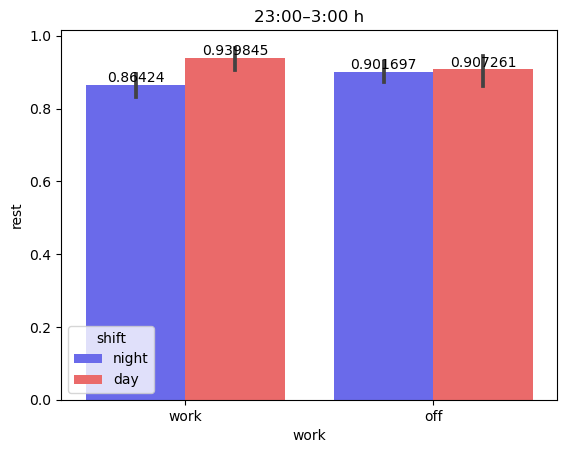


------------------------------------------

on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *rest* between the hours of *3:00–7:00 h* ?
work 3:00–7:00 h 0.034467656157217745 *
off 3:00–7:00 h 0.3176447299854959


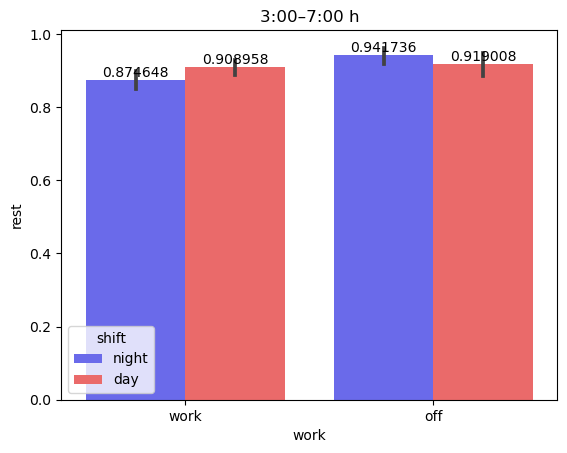


------------------------------------------

on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *rest* between the hours of *7:00–11:00 h* ?
work 7:00–11:00 h 8.619878000514936e-08 **
off 7:00–11:00 h 4.227081558573983e-05 **


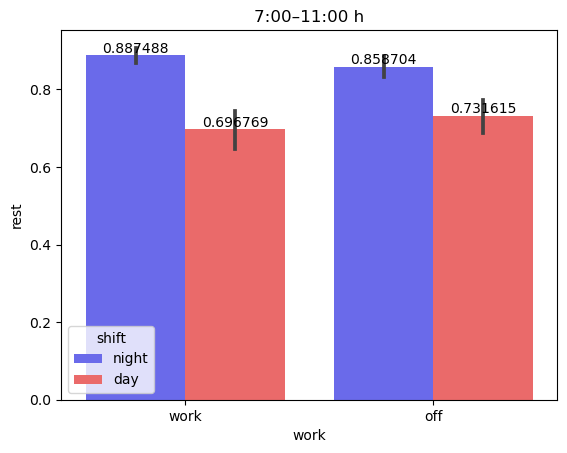


------------------------------------------

on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *rest* between the hours of *11:00–15:00 h* ?
work 11:00–15:00 h 3.4607602310832224e-10 **
off 11:00–15:00 h 0.0014633834767751209 **


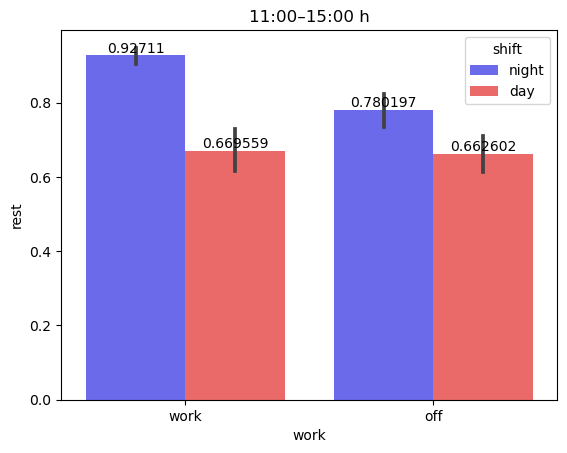


------------------------------------------

on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *rest* between the hours of *15:00–19:00 h* ?
work 15:00–19:00 h 0.0005307693939729534 **
off 15:00–19:00 h 0.006678714852473861 **


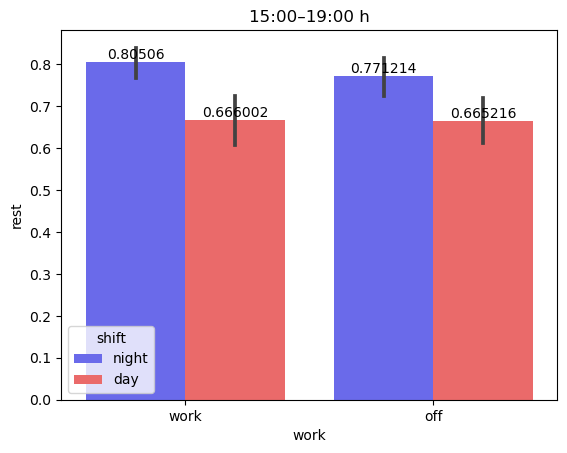


------------------------------------------

on both *work* day and *off* day, what is the effect of primarily *day-shift* nurses and primarily *night-shift* nurses on *rest* between the hours of *19:00–23:00 h* ?
work 19:00–23:00 h 0.8008084258659025
off 19:00–23:00 h 0.1464445427328482


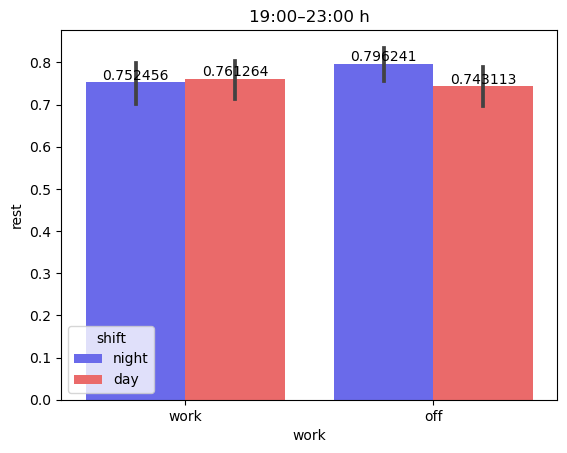

In [ ]:
figure_two(figure_2_sqs, modified_work_df, modified_off_df)